In [21]:
import keras as ks
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
import mpl_finance as mpf
from mpl_finance import candlestick_ohlc
import matplotlib.ticker as mticker
from datetime import date
from matplotlib.dates import date2num
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import plotly.graph_objects as go
import yfinance as yf

Basic LSTM Creation Overview

1. Prepare the data.
2. Feature Scaling (Preprocessing of data)
3. Split the dataset for train and test.
4. Converting features into NumPy array and reshaping the array into shape accepted by LSTM model.
5. Build the architecture for LSTM network.
6. Compile and fit the model (Training)

In [24]:
! pip install colorlover


In [2]:
spy = yf.download(
        tickers = "SPY",
        period = "1mo",
        interval = "5m",
        group_by = 'column',
        auto_adjust = False,
        prepost = False,
        threads = True,
        proxy = None
    )

[*********************100%***********************]  1 of 1 completed


In [3]:
data = spy
data = spy.filter(['Close'])

In [4]:
# Convert the dataframe to numpy array
df = data.values

In [5]:
# Get the number of rows to train the model on
training_data_len = int(np.ceil(len(df)*.8))
training_data_len

1375

In [6]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

In [7]:
#Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]

In [8]:
#Split the data into x_train and y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [9]:
#convert the x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [10]:
#reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [11]:
#Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

In [12]:
#compile and fit
lstm_model.compile(optimizer='adam',loss='mean_squared_error')
lstm_model.fit(x_train,y_train,epochs=50,batch_size=32)

Epoch 1/50
42/42 [==============================] - 6s 67ms/step - loss: 0.0866
Epoch 2/50
42/42 [==============================] - 3s 61ms/step - loss: 0.0021
Epoch 3/50
42/42 [==============================] - 2s 57ms/step - loss: 0.0011
Epoch 4/50
42/42 [==============================] - 2s 50ms/step - loss: 0.0012
Epoch 5/50
42/42 [==============================] - 2s 54ms/step - loss: 0.0013
Epoch 6/50
42/42 [==============================] - 2s 49ms/step - loss: 0.0012
Epoch 7/50
42/42 [==============================] - 2s 50ms/step - loss: 0.0011
Epoch 8/50
42/42 [==============================] - 2s 58ms/step - loss: 0.0010
Epoch 9/50
42/42 [==============================] - 3s 63ms/step - loss: 9.9775e-04
Epoch 10/50
42/42 [==============================] - 3s 62ms/step - loss: 9.9683e-04
Epoch 11/50
42/42 [==============================] - 2s 55ms/step - loss: 0.0012
Epoch 12/50
42/42 [==============================] - 3s 61ms/step - loss: 0.0011
Epoch 13/50
42/42 [==========

In [13]:
#Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = df[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [14]:
#Convert to numpy array
x_test = np.array(x_test)

In [15]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [16]:
#get model predictions
preds = lstm_model.predict(x_test)
preds = scaler.inverse_transform(preds)

In [17]:
#Get RMSE
rmse = np.sqrt(np.mean(((preds - y_test) **2)))
rmse

0.5889951952445686

In [18]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 25)                1625      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


In [19]:
lstm_model.save("saved_model_1.h5")

/Users/andrewbanner/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



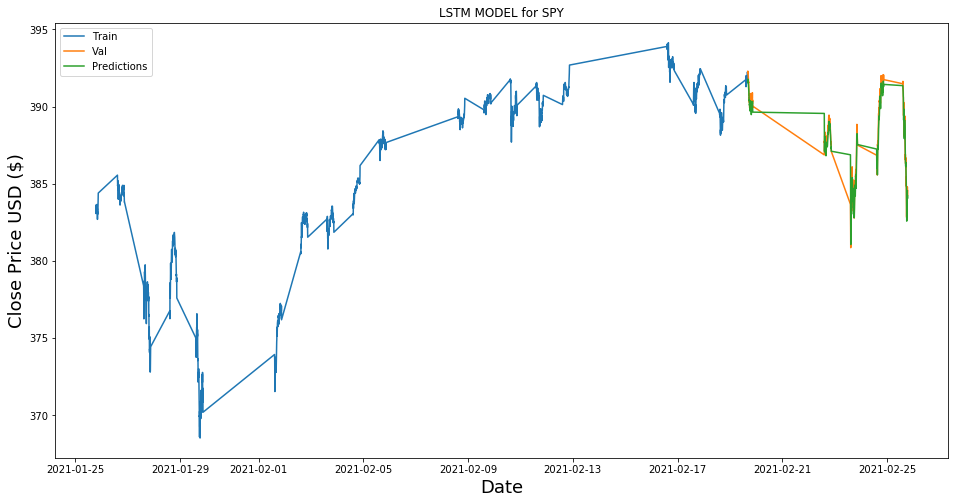

In [20]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = preds
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('LSTM MODEL for SPY')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
plt.show()